In [44]:
import pymongo
import sys
import importlib
import pandas as pd
sys.path.append(r'C:\work\src\news_scraper')

In [16]:
import dao.mongodb_dao
importlib.reload(dao.mongodb_dao)
from dao.mongodb_dao import MongoDbDao

In [12]:
from news_collector import app_config

# Retrieve Data from MongoDB database, and filter out NaNs

In [17]:
mongo_dao = MongoDbDao(app_config.db_conn_string)

In [92]:
df = mongo_dao.get_df_from_db(collection_name=app_config.collection_name, no_id=False)

In [93]:
df = df[['tag_text', 'article_text']]

In [94]:
filtered_df = df[df['article_text'].apply(lambda x: len(x) > 0)]

In [95]:
len(filtered_df)

275

# Firstly, add category_id to each row, and create mapping dictionaries

In [96]:
filtered_df['category_id'] = filtered_df['tag_text'].factorize()[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
category_id_df = filtered_df[['tag_text', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'tag_text']].values)

# Check distributions with bar chart

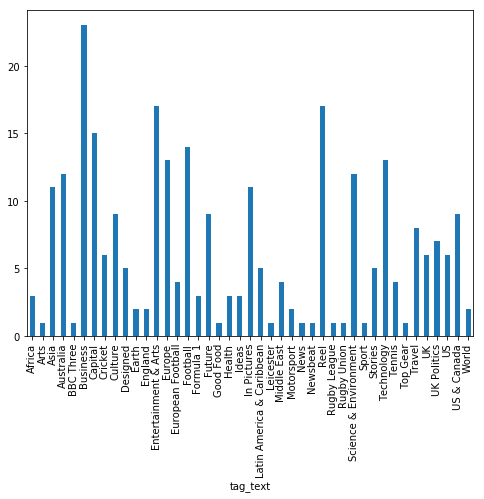

In [98]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
filtered_df.groupby('tag_text')['article_text'].count().plot.bar(ylim=0)
plt.show()

# Apply TfidfVectorizer: Term-Frequency Inverse Document Frequency
- Scoring words on each document, give higher scores on frequent words on the specific category (Term-Frequency), weight down on words that are used on whole documents (Inverse Document Frequency)
- The result of fit_transform is features that contains Tfidf scores of words.

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(filtered_df['article_text']).toarray()
labels = filtered_df.category_id
features.shape

(275, 3050)

# Apply Chi-square to features to select terms with two highest scores

In [100]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for tag, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(tag))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Africa':
  . Most correlated unigrams:
. photos
. reuters
  . Most correlated bigrams:
. want make
. world week
# 'Arts':
  . Most correlated unigrams:
. magazine
. ultimate
  . Most correlated bigrams:
. told bbc
. year old
# 'Asia':
  . Most correlated unigrams:
. documentary
. wearing
  . Most correlated bigrams:
. vice president
. human rights
# 'Australia':
  . Most correlated unigrams:
. melbourne
. australian
  . Most correlated bigrams:
. media reported
. police say
# 'BBC Three':
  . Most correlated unigrams:
. surrounded
. drinking
  . Most correlated bigrams:
. told bbc
. year old
# 'Business':
  . Most correlated unigrams:
. invest
. revenues
  . Most correlated bigrams:
. chief executive
. says mr
# 'Capital':
  . Most correlated unigrams:
. jobs
. class
  . Most correlated bigrams:
. capital head
. bbc capital
# 'Cricket':
  . Most correlated unigrams:
. captain
. cricket
  . Most correlated bigrams:
. bbc sport
. south africa
# 'Culture':
  . Most correlated unigrams:

# Multi-Class Classifier: Features and Design
- To train supervised classifiers, we first transformed the “article_text” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
- After having this vector representations of the text we can train supervised classifiers to train unseen “article_text” and predict the “tag_text” on which they fall.

After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

- Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(filtered_df['article_text'], filtered_df['tag_text'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [110]:
print(clf.predict(count_vect.transform([filtered_df['article_text'].iloc[5]])))

['Business']


In [111]:
filtered_df['tag_text'].iloc[5]

'Science & Environment'

# Model Selection
We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The mi

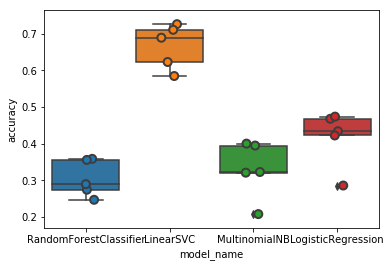

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [113]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.666456
LogisticRegression        0.416665
MultinomialNB             0.329173
RandomForestClassifier    0.304893
Name: accuracy, dtype: float64

# Proceed with the best model
- Obtain confusion matrix to check the accuracy with heatmap

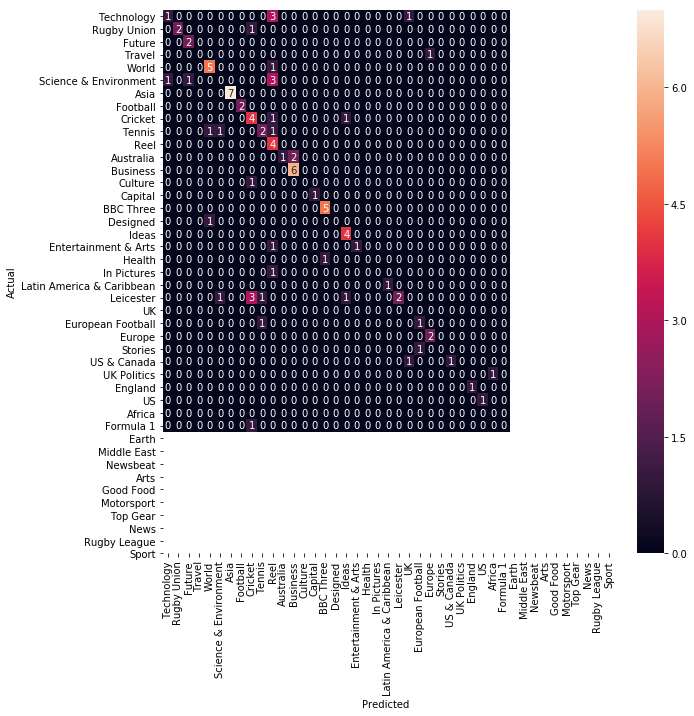

In [114]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, filtered_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['tag_text'].values, yticklabels=category_id_df['tag_text'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Check mis-predicted data

In [115]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if (actual >= len(conf_mat)) or (predicted >= conf_mat.shape[1]):
        continue
    if predicted != actual and conf_mat[actual, predicted] >= 3:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(filtered_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['tag_text', 'article_text']])
      print('')

'Leicester' predicted as 'Cricket' : 3 examples.


,tag_text,article_text



'Technology' predicted as 'Reel' : 3 examples.


,tag_text,article_text



'Science & Environment' predicted as 'Reel' : 3 examples.


,tag_text,article_text


# Check top unigrams and bigrams with the chosen model

In [116]:
model = LinearSVC()
model.fit(features, labels)
N = 2
for tag, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(tag))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Africa':
  . Top unigrams:
       . reuters
       . photos
  . Top bigrams:
       . world week
       . want make
# 'Arts':
  . Top unigrams:
       . ultimate
       . magazine
  . Top bigrams:
       . things like
       . don like
# 'Asia':
  . Top unigrams:
       . chinese
       . saying
  . Top bigrams:
       . human rights
       . vice president
# 'Australia':
  . Top unigrams:
       . australian
       . melbourne
  . Top bigrams:
       . media reported
       . earlier month
# 'BBC Three':
  . Top unigrams:
       . drinking
       . surrounded
  . Top bigrams:
       . bbc travel
       . 10 years
# 'Business':
  . Top unigrams:
       . business
       . company
  . Top bigrams:
       . says mr
       . chief executive
# 'Capital':
  . Top unigrams:
       . class
       . jobs
  . Top bigrams:
       . bbc capital
       . capital head
# 'Cricket':
  . Top unigrams:
       . cricket
       . test
  . Top bigrams:
       . south africa
       . bbc sport
# 'Cultur

In [117]:
# y_test could have missing ids if the number of samples is not sufficiently big.
def find_missing_idx(idx_series, whole_ids):
    total_num = len(whole_ids.unique())
    missing_numbers = [x for x in range(0, total_num) if x not in idx_series.unique()]
    return missing_numbers

In [118]:
from sklearn import metrics
# target_names_list = filtered_df['tag_text'].unique()
missing_ids = find_missing_idx(y_test, filtered_df['tag_text'])
target_names_list = category_id_df[~category_id_df['category_id'].isin(missing_ids)]['tag_text'].tolist()
target_labels_list = category_id_df[~category_id_df['category_id'].isin(missing_ids)]['category_id'].tolist()
print(metrics.classification_report(y_test, y_pred, target_names=target_names_list, labels=target_labels_list))

                           precision    recall  f1-score   support

               Technology       0.50      0.20      0.29         5
                   Future       1.00      0.67      0.80         3
                   Travel       0.67      1.00      0.80         2
                    World       0.00      0.00      0.00         1
    Science & Environment       0.71      0.83      0.77         6
                     Asia       0.00      0.00      0.00         5
                 Football       1.00      1.00      1.00         7
                  Cricket       1.00      1.00      1.00         2
                     Reel       0.40      0.67      0.50         6
                Australia       0.50      0.40      0.44         5
                 Business       0.27      1.00      0.42         4
                  Culture       1.00      0.33      0.50         3
                  Capital       0.75      1.00      0.86         6
                BBC Three       0.00      0.00      0.00     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
